# 1. import needed package

In [1]:
from mxnet import autograd
from mxnet import gluon
from mxnet import image
from mxnet import init
from mxnet import nd
from mxnet.gluon.model_zoo import vision as model
from mxnet.gluon import nn
from mxnet.gluon.data import vision
import numpy as np
import random
import mxnet as mx
import sys
sys.path.insert(0, '../../utils')
from dataset import *
from netlib import *
import os
import shutil
import utils

ctx = mx.gpu(0)

def mkdir_if_not_exist(path):
    if not os.path.exists(os.path.join(*path)):
        os.makedirs(os.path.join(*path))
        
arrayds_dir = '/home/hui/dataset/CIFAR10/arraydataset/'

# 2. data loader, data argument

In [2]:
"""
data loader
"""
def _transform_test(data, label):
    im = data.astype('float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), mean=np.array([0.4914, 0.4822, 0.4465]),
                                   std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1))
    return im, nd.array([label]).astype('float32')

def load_all_data_label(pathes):
    all_data, all_label = None, None
    for path in pathes:
        data, label = nd.load(path)
        label = label.reshape((-1,)).astype('float32')
        if all_data is None:
            all_data, all_label = data, label
        else:
            all_data = nd.concat(all_data, data, dim=0)
            all_label = nd.concat(all_label, label, dim=0)
    return all_data, all_label


def data_loader(batch_size, transform_train, transform_test=None, num_workers=0, pathes=None, arrayds=False, train_shuffle=True):
    if transform_train is None:
        transform_train = _transform_train
    if transform_test is None:
        transform_test = _transform_test
        
    # flag=1 mean 3 channel image
    if pathes is None:
        train_ds = gluon.data.vision.datasets.CIFAR10(train=True, transform=transform_train)
    else:
        if not arrayds:
            train_ds = MultiFolderDataset(pathes, transform=transform_train)
        else:
            train_ds = MyArrayDataset(load_all_data_label(pathes), transform=transform_train)
    test_ds = gluon.data.vision.datasets.CIFAR10(train=False, transform=transform_test)

    loader = gluon.data.DataLoader
    train_data = loader(train_ds, batch_size, shuffle=train_shuffle, last_batch='keep', num_workers=num_workers)
    test_data = loader(test_ds, batch_size, shuffle=False, last_batch='keep', num_workers=num_workers)
    return train_data, test_data

In [3]:
"""
data argument
"""
def transform_train_DA1(data, label):
    im = data.asnumpy()
    im = np.pad(im, ((4, 4), (4, 4), (0, 0)), mode='constant', constant_values=0)
    im = nd.array(im, dtype='float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, rand_mirror=True,
                                    rand_crop=True,
                                   mean=np.array([0.4914, 0.4822, 0.4465]),
                                   std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1)) # channel x width x height
    return im, nd.array([label]).astype('float32')


def transform_train_DA2(data, label):
    im = data.astype(np.float32) / 255
    auglist = [image.RandomSizedCropAug(size=(32, 32), min_area=0.49, ratio=(0.5, 2))]
    _aug = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, 
                                rand_crop=False, rand_resize=False, rand_mirror=True,
                                mean=np.array([0.4914, 0.4822, 0.4465]),
                                std=np.array([0.2023, 0.1994, 0.2010]),
                                brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3,
                                pca_noise=0.01, rand_gray=0, inter_method=2)
    auglist.append(image.RandomOrderAug(_aug))
    
    for aug in auglist:
        im = aug(im)
    
    im = nd.transpose(im, (2, 0, 1))
    return (im, nd.array([label]).asscalar().astype('float32'))
    

random_clip_rate = 0.3
def transform_train_DA3(data, label):
    im = data.astype(np.float32) / 255
    auglist = [image.RandomSizedCropAug(size=(32, 32), min_area=0.49, ratio=(0.5, 2))]
    _aug = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, 
                                rand_crop=False, rand_resize=False, rand_mirror=True,
#                                mean=np.array([0.4914, 0.4822, 0.4465]),
#                                std=np.array([0.2023, 0.1994, 0.2010]),
                                brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3,
                                pca_noise=0.01, rand_gray=0, inter_method=2)
    auglist.append(image.RandomOrderAug(_aug))

    for aug in auglist:
        im = aug(im)
        
    if random.random() > random_clip_rate:
        im = im.clip(0, 1)
    _aug = image.ColorNormalizeAug(mean=np.array([0.4914, 0.4822, 0.4465]),
                   std=np.array([0.2023, 0.1994, 0.2010]),)
    im = _aug(im)
    
    im = nd.transpose(im, (2, 0, 1))
    return (im, nd.array([label]).asscalar().astype('float32'))

# 3. data augment: back grad

## 3.1 define a simple back grad method

In [4]:
from cifar10_utils import show_images
%matplotlib inline

def SGD(data, lr):
    data[:] = data - data.grad * lr
    
def inv_normalize(data, clip=True):
    mean=np.array([0.4914, 0.4822, 0.4465])
    std=np.array([0.2023, 0.1994, 0.2010])
    images = data.transpose((0, 2, 3, 1)).asnumpy()
    images = images * std + mean
    images = images.transpose((0, 3, 1, 2)) * 255
    if clip: 
        images = images.clip(0, 255)
    return images
    
def show_data(data, clip=True):
    images = inv_normalize(data, clip)
    show_images(images)
    
def generate_backgrad_data(net, data, label, max_iters=60, lr=0.1, iter_log=False, clip=True, combine_batch=False):
    for iters in range(1, max_iters+1):
        with autograd.record():
            data.attach_grad()
            output = net(data.as_in_context(ctx))
            loss = -loss_f(output, label.as_in_context(ctx))
        loss.backward()
        
        if iter_log and iters % 10 == 0:
            show_data(data[:10], clip)
            #print data[0, 0, :2, :10]
            #print data.grad[0, 0, :2, :10]
        if iter_log and iters % 5 == 0:
            print 'iter:', iters, 'loss:', nd.mean(loss).asscalar()
        
        SGD(data, lr)
    return data, (loss,)

def get_soft_label(y, num_class, soft_label_th):
    y = y.reshape((-1,))
    ny = (y.one_hot(num_class) + soft_label_th / num_class)
    y = y.asnumpy()
    ny[range(y.shape[0]), y.astype('int32')] -= soft_label_th
    return nd.array(ny)

# 4. analysis trained net acc
```
net1: train with orign data (resnet18_me_200e)
net2: train with iter10 and origin data
net3: train with iter15 and origin data
online net: train with iter10 in online way
```
net | transform | backgrad (iter, lr, net, shuffle) | acc
---| --- | --- | --- 
net1 | DA1 | (10, 0.1, net1, true) | 0.444
net2 | DA1 | (10, 0.1, net1, true) | 1.0
net3 | DA1 | (10, 0.1, net1, true) | 0.99958
online net| DA1 | (10, 0.1, net1, true) | 0.99438
online net | DA1 | (10, 0.1, online net, true) | 0.99636
online net | test | (10, 0.1, online net, true) | 0.8971
online net | DA1 | (10, 0.1, online net, false) | 0.20748
online net | test| (10, 0.1, online net, false) | 0.20062


## 4.1 compare datasets' shuffle order
**[origin.ndarray]** is same as **[origin folder]**, not shuffle<br/>
**[CIFAR10]** and **[backgrad image]**, use shuffle</br>

### 4.1.1 why shuffle influence backgrad result?
```
y = wx + b
loss = 
```

In [5]:
train_ds = MyArrayDataset(load_all_data_label([arrayds_dir + 'origin.ndarray']), transform=_transform_test)
train_data = gluon.data.DataLoader(train_ds, 32, shuffle=False, num_workers=0)
for data, label in train_data:
    print label.T
    break


[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
<NDArray 1x32 @cpu(0)>


In [6]:
train_ds = MyArrayDataset(load_all_data_label([arrayds_dir +'backgrad_resnet18_me_200e_iter10.ndarray']), transform=_transform_test)
train_data = gluon.data.DataLoader(train_ds, 32, shuffle=False, num_workers=0)
for data, label in train_data:
    print label.T
    break


[[ 6.  9.  9.  4.  1.  1.  2.  7.  8.  3.  4.  7.  7.  2.  9.  9.  9.  3.
   2.  6.  4.  3.  6.  6.  2.  6.  3.  5.  4.  0.  0.  9.]]
<NDArray 1x32 @cpu(0)>


In [7]:
train_ds = gluon.data.vision.datasets.CIFAR10(train=True, transform=_transform_test)
train_data = gluon.data.DataLoader(train_ds, 32, shuffle=False, num_workers=0)
for data, label in train_data:
    print label.T
    break


[[ 6.  9.  9.  4.  1.  1.  2.  7.  8.  3.  4.  7.  7.  2.  9.  9.  9.  3.
   2.  6.  4.  3.  6.  6.  2.  6.  3.  5.  4.  0.  0.  9.]]
<NDArray 1x32 @cpu(0)>


In [12]:
train_ds = MultiFolderDataset(["/home/hui/dataset/CIFAR10/origin/"], transform=None) 
train_data = gluon.data.DataLoader(train_ds, 32, shuffle=False, num_workers=0)
for data, label in train_data:
    print label.T
    break


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
<NDArray 32 @cpu(0)>


## 4.2 cal acc for diffrent shuffle and DA condition
```
diffs is L2Norm of images diff = sqrt(sum((f(i) - f_hat(i))^2))
MSE = sum((f(i) - f_hat(i))^2) / N
SNR = 10 * log_10( sum(f(i)^2) / sum((f(i)-f_hat(i))^2) )
```

In [5]:
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()
def cal_prec():
    num, right, loss = 0., 0., 0.
    for i, (data, label) in enumerate(train_data):
        grad_data, (_loss, ) = generate_backgrad_data(net, data.copy(), label, max_iters=10, lr=0.1, clip=False)
        output = net(grad_data.as_in_context(ctx))
        result = output.argmax(axis=1)
        right += nd.sum(result == label.reshape(shape=result.shape).as_in_context(ctx)).asscalar()
        num += data.shape[0]
        loss += _loss
    print right / num , loss / num
    
def load_data(idx):
    data2, label2 = [], []
    for i in idx:
        _data, _label = train_ds[i]
        data2.append(_data.asnumpy())
        label2.append(_label.asnumpy())
    data2, label2 = nd.array(data2), nd.array(label2)
    return data2, label2

def collect_BN(blocks):
    BN = []
    for blk in blocks:
        _type = str(blk).split('(')[0]
        if _type == 'BatchNorm':
            BN.append(blk)
        elif _type == 'Residual':
            BN.extend([blk.bn1, blk.bn2])
    return BN

class BNControl():
    def __init__(self, blocks, use_batch=True):
        self.bns = collect_BN(blocks)
        self.use_batch = use_batch
        
    def store(self):
        self.data_list = []
        if self.use_batch: # use batch data and no change running mean/std
            for bn in self.bns:
                self.data_list.append(bn.params.get('running_mean').data().copy())
                self.data_list.append(bn.params.get('running_var').data().copy())
        else: # no use batch data and no change running mean/std
            for bn in self.bns:
                self.data_list.append(n._kwargs['use_global_stats'])
                bn._kwargs['use_global_stats'] = True
        
    def load(self):
        if self.use_batch:
            for i in range(len(self.bns)):
                bn, mean, std = self.bns[i], self.data_list[2*i], self.data_list[2*i+1]
                bn.params.get('running_mean').set_data(mean)
                bn.params.get('running_var').set_data(std)
        else:
            for i in range(len(self.bns)):
                bn, data = self.bns[i], self.data_list[i]
                bn._kwargs['use_global_stats'] = data
            
def get_info(train_data, net, clip=False, lr=0.1, use_batch=True, more=True):
    diffs, losses, right, num = None, None, 0, 0
    bn_backup = BNControl(net.net, use_batch)
    for data, label in train_data:
        bn_backup.store()
        backgrad_data, (_loss, ) = generate_backgrad_data(net, data.copy(), label, max_iters=10, lr=lr, clip=clip)
        bn_backup.load()
        diff = nd.sqrt(nd.sum((backgrad_data - data) ** 2, axis=0, exclude=True))
        MSE = nd.mean((backgrad_data - data) ** 2, axis=0, exclude=True)
        Savg = nd.mean((data) ** 2, axis=0, exclude=True)
        SNR = 10 * nd.log10(Savg / MSE)
        if diffs is None: 
            diffs = diff
            losses = _loss
        else: 
            diffs = nd.concat(diffs, diff, dim=0)
            losses = nd.concat(losses, _loss, dim=0)
            
        output = net(backgrad_data.as_in_context(ctx))
        result = output.argmax(axis=1)
        right += nd.sum(result == label.reshape(shape=result.shape).as_in_context(ctx)).asscalar()
        num += data.shape[0]
        
    diffs, losses = diffs.asnumpy(), losses.asnumpy()
    if not more: 
        return diffs, losses, right / num
    else:
        return diffs, losses, right / num, MSE.asnumpy(), SNR.asnumpy()

statistic_list = []
def statistic(diffs):
    t = np.mean(diffs), np.max(diffs), np.min(diffs), np.std(diffs)
    statistic_list.append(t)
    return t

In [7]:
net = ResNet(10, prefix='resnet18_')
net.initialize(ctx=ctx)
net.hybridize()
net.load_params("../../models/resnet18_me_backgrad_prob_online_iter10_lr01", ctx=ctx)

### 4.2.1 [shuffle=True, DA=DA1, batch=128]

In [7]:
net.load_params("../../models/resnet18_me_backgrad_prob_online_iter10_lr01", ctx=ctx)
train_ds = MyArrayDataset(load_all_data_label([arrayds_dir + 'origin.ndarray']), transform=transform_train_DA1)
train_data = gluon.data.DataLoader(train_ds, 128, shuffle=True, num_workers=1)
diffs, losses, acc, MSE, SNR = get_info(train_data, net, False)
print "diff(mean, max, min, std):", statistic(diffs)
print "loss(mean, max, min, std):", statistic(losses)
print "MSE(mean, max, min, std):", statistic(MSE)
print "SNR(mean, max, min, std):", statistic(SNR)
print "acc", acc

diff(mean, max, min, std): (0.028494909, 3.3918405, 0.00069388968, 0.12571354)
loss(mean, max, min, std): (-0.022742826, 0.0, -14.43439, 0.29769403)
MSE(mean, max, min, std): (9.3517256e-06, 0.00071546668, 1.0481064e-08, 7.9468853e-05)
SNR(mean, max, min, std): (73.995811, 84.964874, 33.778755, 7.4875011)
acc 0.99518


### 4.2.2 [shuffle=False, DA=DA1, , batch=128]

In [8]:
net.load_params("../../models/resnet18_me_backgrad_prob_online_iter10_lr01", ctx=ctx)
train_ds = MyArrayDataset(load_all_data_label([arrayds_dir + 'origin.ndarray']), transform=transform_train_DA1)
train_data = gluon.data.DataLoader(train_ds, 128, shuffle=False, num_workers=1)
diffs, losses, acc, MSE, SNR = get_info(train_data, net, False)
print "diff(mean, max, min, std):", statistic(diffs)
print "loss(mean, max, min, std):", statistic(losses)
print "MSE(mean, max, min, std):", statistic(MSE)
print "SNR(mean, max, min, std):", statistic(SNR)
print "acc", acc

diff(mean, max, min, std): (1.88191, 3.992785, 0.30802137, 0.47699493)
loss(mean, max, min, std): (-8.9447355, -1.1920928e-07, -27.180946, 5.843267)
MSE(mean, max, min, std): (0.0011198835, 0.0024220361, 0.00022511593, 0.00054084428)
SNR(mean, max, min, std): (33.599243, 41.200562, 25.594713, 3.1359203)
acc 0.20782


### 4.2.3 [shuffle=True, DA=test, batch=128]

In [9]:
net.load_params("../../models/resnet18_me_backgrad_prob_online_iter10_lr01", ctx=ctx)
train_ds = MyArrayDataset(load_all_data_label([arrayds_dir + 'origin.ndarray']), transform=_transform_test)
train_data = gluon.data.DataLoader(train_ds, 128, shuffle=True, num_workers=1)
diffs, losses, acc, MSE, SNR = get_info(train_data, net, False)
print "diff(mean, max, min, std):", statistic(diffs)
print "loss(mean, max, min, std):", statistic(losses)
print "MSE(mean, max, min, std):", statistic(MSE)
print "SNR(mean, max, min, std):", statistic(SNR)
print "acc", acc

diff(mean, max, min, std): (0.29054788, 4.1743436, 0.022378938, 0.61034387)
loss(mean, max, min, std): (-0.61029178, 0.0, -22.683092, 2.1617498)
MSE(mean, max, min, std): (8.3960098e-05, 0.001938233, 3.2515015e-07, 0.00031700777)
SNR(mean, max, min, std): (56.967419, 71.148331, 28.264088, 8.7912121)
acc 0.89788


### 4.2.4 [shuffle=False, DA=test, batch=128]

In [10]:
net.load_params("../../models/resnet18_me_backgrad_prob_online_iter10_lr01", ctx=ctx)
train_ds = MyArrayDataset(load_all_data_label([arrayds_dir + 'origin.ndarray']), transform=_transform_test)
train_data = gluon.data.DataLoader(train_ds, 128, shuffle=False, num_workers=1)
diffs, losses, acc, MSE, SNR = get_info(train_data, net, False)
print "diff(mean, max, min, std):", statistic(diffs)
print "loss(mean, max, min, std):", statistic(losses)
print "MSE(mean, max, min, std):", statistic(MSE)
print "SNR(mean, max, min, std):", statistic(SNR)
print "acc", acc

diff(mean, max, min, std): (2.0169327, 4.0331383, 0.10229762, 0.54460007)
loss(mean, max, min, std): (-10.091663, 0.0, -30.55941, 6.5080519)
MSE(mean, max, min, std): (0.0013005364, 0.0029557087, 5.6318851e-05, 0.00066486845)
SNR(mean, max, min, std): (32.243858, 47.006248, 24.992386, 4.0868025)
acc 0.2006


### 4.2.5 [shuffle=False/True, DA=DA1, batch=64/16/4]

In [11]:
net.load_params("../../models/resnet18_me_backgrad_prob_online_iter10_lr01", ctx=ctx)
train_ds = MyArrayDataset(load_all_data_label([arrayds_dir + 'origin.ndarray']), transform=transform_train_DA1)
train_data = gluon.data.DataLoader(train_ds, 64, shuffle=False, num_workers=1)
diffs, losses, acc, MSE, SNR = get_info(train_data, net, False)
print "diff(mean, max, min, std):", statistic(diffs)
print "loss(mean, max, min, std):", statistic(losses)
print "MSE(mean, max, min, std):", statistic(MSE)
print "SNR(mean, max, min, std):", statistic(SNR)
print "acc", acc

net.load_params("../../models/resnet18_me_backgrad_prob_online_iter10_lr01", ctx=ctx)
train_data = gluon.data.DataLoader(train_ds, 16, shuffle=False, num_workers=2)
diffs, losses, acc, MSE, SNR = get_info(train_data, net, False)
print "diff(mean, max, min, std):", statistic(diffs)
print "loss(mean, max, min, std):", statistic(losses)
print "MSE(mean, max, min, std):", statistic(MSE)
print "SNR(mean, max, min, std):", statistic(SNR)
print "acc", acc

net.load_params("../../models/resnet18_me_backgrad_prob_online_iter10_lr01", ctx=ctx)
train_data = gluon.data.DataLoader(train_ds, 4, shuffle=False, num_workers=4)
diffs, losses, acc, MSE, SNR = get_info(train_data, net, False)
print "diff(mean, max, min, std):", statistic(diffs)
print "loss(mean, max, min, std):", statistic(losses)
print "MSE(mean, max, min, std):", statistic(MSE)
print "SNR(mean, max, min, std):", statistic(SNR)
print "acc", acc

diff(mean, max, min, std): (1.8838433, 3.7017679, 0.31961626, 0.47159871)
loss(mean, max, min, std): (-8.9813509, -4.7683704e-07, -28.714834, 5.8291774)
MSE(mean, max, min, std): (0.0011472163, 0.0025083763, 0.00027305388, 0.00063792925)
SNR(mean, max, min, std): (33.741013, 40.696381, 30.339308, 2.8150489)
acc 0.20516
diff(mean, max, min, std): (1.8690258, 3.5410726, 0.38470805, 0.46444008)
loss(mean, max, min, std): (-8.8592558, -5.9604628e-07, -30.206085, 5.7361321)
MSE(mean, max, min, std): (0.001149121, 0.0026288314, 0.00029044444, 0.00073690451)
SNR(mean, max, min, std): (34.026974, 38.499325, 28.34347, 3.2199061)
acc 0.20234
diff(mean, max, min, std): (1.7316468, 2.9996088, 0.41312093, 0.39536244)
loss(mean, max, min, std): (-7.8708744, -3.3378547e-06, -22.669514, 5.1155677)
MSE(mean, max, min, std): (0.0013707757, 0.001908671, 0.00083447184, 0.00038413703)
SNR(mean, max, min, std): (32.621582, 35.291428, 29.830114, 1.9481026)
acc 0.20828


In [12]:
net.load_params("../../models/resnet18_me_backgrad_prob_online_iter10_lr01", ctx=ctx)
train_ds = MyArrayDataset(load_all_data_label([arrayds_dir + 'origin.ndarray']), transform=transform_train_DA1)
train_data = gluon.data.DataLoader(train_ds, 64, shuffle=True, num_workers=1)
diffs, losses, acc, MSE, SNR = get_info(train_data, net, False)
print "diff(mean, max, min, std):", statistic(diffs)
print "loss(mean, max, min, std):", statistic(losses)
print "MSE(mean, max, min, std):", statistic(MSE)
print "SNR(mean, max, min, std):", statistic(SNR)
print "acc", acc

net.load_params("../../models/resnet18_me_backgrad_prob_online_iter10_lr01", ctx=ctx)
train_data = gluon.data.DataLoader(train_ds, 16, shuffle=True, num_workers=2)
diffs, losses, acc, MSE, SNR = get_info(train_data, net, False)
print "diff(mean, max, min, std):", statistic(diffs)
print "loss(mean, max, min, std):", statistic(losses)
print "MSE(mean, max, min, std):", statistic(MSE)
print "SNR(mean, max, min, std):", statistic(SNR)
print "acc", acc

net.load_params("../../models/resnet18_me_backgrad_prob_online_iter10_lr01", ctx=ctx)
train_data = gluon.data.DataLoader(train_ds, 4, shuffle=True, num_workers=4)
diffs, losses, acc, MSE, SNR = get_info(train_data, net, False)
print "diff(mean, max, min, std):", statistic(diffs)
print "loss(mean, max, min, std):", statistic(losses)
print "MSE(mean, max, min, std):", statistic(MSE)
print "SNR(mean, max, min, std):", statistic(SNR)
print "acc", acc

diff(mean, max, min, std): (0.043912657, 3.5108311, 0.0010162303, 0.17033814)
loss(mean, max, min, std): (-0.040138077, 0.0, -14.060329, 0.44469869)
MSE(mean, max, min, std): (0.00018660276, 0.0015834171, 1.4203597e-05, 0.00041801811)
SNR(mean, max, min, std): (46.512646, 52.255779, 31.890083, 5.8562565)
acc 0.99174
diff(mean, max, min, std): (0.21157566, 3.7815757, 0.00047161517, 0.46322441)
loss(mean, max, min, std): (-0.31422919, 0.0, -20.077579, 1.5802054)
MSE(mean, max, min, std): (2.077647e-07, 2.8725174e-06, 5.6377378e-09, 6.8988572e-07)
SNR(mean, max, min, std): (78.703003, 85.864983, 57.620388, 7.1278205)
acc 0.95466
diff(mean, max, min, std): (0.7936213, 3.6437559, 0.00011887825, 0.81286031)
loss(mean, max, min, std): (-1.7225989, -3.5762781e-07, -21.390085, 3.657903)
MSE(mean, max, min, std): (0.0003059117, 0.0010284547, 2.9910567e-05, 0.00041810304)
SNR(mean, max, min, std): (43.115753, 47.742851, 34.632996, 5.1407228)
acc 0.80456


### 4.2.6 [shuffle=False/True, DA=test, batch=64/16/4]

In [13]:
train_ds = MyArrayDataset(load_all_data_label([arrayds_dir + 'origin.ndarray']), transform=_transform_test)
net.load_params("../../models/resnet18_me_backgrad_prob_online_iter10_lr01", ctx=ctx)
train_data = gluon.data.DataLoader(train_ds, 64, shuffle=False, num_workers=1)
diffs, losses, acc, MSE, SNR = get_info(train_data, net, False)
print "diff(mean, max, min, std):", statistic(diffs)
print "loss(mean, max, min, std):", statistic(losses)
print "MSE(mean, max, min, std):", statistic(MSE)
print "SNR(mean, max, min, std):", statistic(SNR)
print "acc", acc

net.load_params("../../models/resnet18_me_backgrad_prob_online_iter10_lr01", ctx=ctx)
train_data = gluon.data.DataLoader(train_ds, 16, shuffle=False, num_workers=2)
diffs, losses, acc, MSE, SNR = get_info(train_data, net, False)
print "diff(mean, max, min, std):", statistic(diffs)
print "loss(mean, max, min, std):", statistic(losses)
print "MSE(mean, max, min, std):", statistic(MSE)
print "SNR(mean, max, min, std):", statistic(SNR)
print "acc", acc

net.load_params("../../models/resnet18_me_backgrad_prob_online_iter10_lr01", ctx=ctx)
train_data = gluon.data.DataLoader(train_ds, 4, shuffle=False, num_workers=4)
diffs, losses, acc, MSE, SNR = get_info(train_data, net, False)
print "diff(mean, max, min, std):", statistic(diffs)
print "loss(mean, max, min, std):", statistic(losses)
print "MSE(mean, max, min, std):", statistic(MSE)
print "SNR(mean, max, min, std):", statistic(SNR)
print "acc", acc

diff(mean, max, min, std): (2.0169158, 3.9170804, 0.11618762, 0.53681433)
loss(mean, max, min, std): (-10.114234, -1.1920928e-07, -30.134457, 6.4866738)
MSE(mean, max, min, std): (0.001291633, 0.0023317442, 0.00042959428, 0.0005798717)
SNR(mean, max, min, std): (32.017292, 37.366909, 27.361176, 3.0049431)
acc 0.19782
diff(mean, max, min, std): (2.0063128, 3.5781038, 0.14641486, 0.51580262)
loss(mean, max, min, std): (-9.9811077, -2.3841855e-07, -30.220226, 6.3621531)
MSE(mean, max, min, std): (0.001291641, 0.0023317176, 0.00042957338, 0.00057987287)
SNR(mean, max, min, std): (32.017277, 37.367123, 27.361334, 3.0049562)
acc 0.19836
diff(mean, max, min, std): (1.8729905, 3.1071353, 0.30720788, 0.39454892)
loss(mean, max, min, std): (-8.8579588, -8.3446469e-07, -26.050478, 5.5748458)
MSE(mean, max, min, std): (0.0015214706, 0.0018257746, 0.0010449281, 0.00029112995)
SNR(mean, max, min, std): (31.171347, 32.561241, 28.220701, 1.7266445)
acc 0.20378


In [14]:
train_ds = MyArrayDataset(load_all_data_label([arrayds_dir + 'origin.ndarray']), transform=_transform_test)
net.load_params("../../models/resnet18_me_backgrad_prob_online_iter10_lr01", ctx=ctx)
train_data = gluon.data.DataLoader(train_ds, 64, shuffle=True, num_workers=1)
diffs, losses, acc, MSE, SNR = get_info(train_data, net, False)
print "diff(mean, max, min, std):", statistic(diffs)
print "loss(mean, max, min, std):", statistic(losses)
print "MSE(mean, max, min, std):", statistic(MSE)
print "SNR(mean, max, min, std):", statistic(SNR)
print "acc", acc

net.load_params("../../models/resnet18_me_backgrad_prob_online_iter10_lr01", ctx=ctx)
train_data = gluon.data.DataLoader(train_ds, 16, shuffle=True, num_workers=2)
diffs, losses, acc, MSE, SNR = get_info(train_data, net, False)
print "diff(mean, max, min, std):", statistic(diffs)
print "loss(mean, max, min, std):", statistic(losses)
print "MSE(mean, max, min, std):", statistic(MSE)
print "SNR(mean, max, min, std):", statistic(SNR)
print "acc", acc

net.load_params("../../models/resnet18_me_backgrad_prob_online_iter10_lr01", ctx=ctx)
train_data = gluon.data.DataLoader(train_ds, 4, shuffle=True, num_workers=4)
diffs, losses, acc, MSE, SNR = get_info(train_data, net, False)
print "diff(mean, max, min, std):", statistic(diffs)
print "loss(mean, max, min, std):", statistic(losses)
print "MSE(mean, max, min, std):", statistic(MSE)
print "SNR(mean, max, min, std):", statistic(SNR)
print "acc", acc

diff(mean, max, min, std): (0.34288958, 4.2394218, 0.016314542, 0.64143282)
loss(mean, max, min, std): (-0.69974482, 0.0, -23.468046, 2.3701899)
MSE(mean, max, min, std): (0.00019256258, 0.0014425406, 7.4373406e-06, 0.00047046776)
SNR(mean, max, min, std): (47.772453, 53.406746, 30.161434, 6.7372293)
acc 0.88932
diff(mean, max, min, std): (0.5937435, 4.1252971, 0.00083296438, 0.77314824)
loss(mean, max, min, std): (-1.2393742, 0.0, -23.893414, 3.3466334)
MSE(mean, max, min, std): (0.00075870845, 0.0026370173, 6.2895422e-05, 0.00088713499)
SNR(mean, max, min, std): (37.431934, 47.063858, 26.885651, 6.7711134)
acc 0.84192
diff(mean, max, min, std): (1.1930276, 3.8218005, 0.00021730599, 0.88795573)
loss(mean, max, min, std): (-3.0905747, -1.1920928e-07, -28.000971, 4.9415917)
MSE(mean, max, min, std): (3.5898459e-08, 8.0688146e-08, 7.1593198e-09, 3.0698196e-08)
SNR(mean, max, min, std): (80.152084, 86.919846, 73.429398, 5.2954121)
acc 0.68042


### 4.2.6 [shuffle=False/True, DA=test, batch=1]

In [6]:
train_ds = MyArrayDataset(load_all_data_label([arrayds_dir + 'origin.ndarray']), transform=_transform_test)
net = ResNet(10)
net.initialize(ctx=ctx)
net.hybridize()
net.load_params("../../models/resnet18_me_backgrad_prob_online_iter10_lr01", ctx=ctx)

In [8]:
train_data = gluon.data.DataLoader(train_ds, 1, shuffle=False, num_workers=4)
cal_prec()

0.30978 -2.21852635104


In [9]:
net.load_params("../../models/resnet18_me_backgrad_prob_online_iter10_lr01", ctx=ctx)
train_data = gluon.data.DataLoader(train_ds, 1, shuffle=True, num_workers=4)
cal_prec()

0.71512 -2.21852404459


### 4.2.7 [shuffle=True, DA=DA1, lr=0.5] bigger lr

In [15]:
train_ds = MyArrayDataset(load_all_data_label([arrayds_dir + 'origin.ndarray']), transform=transform_train_DA1)
net.load_params("../../models/resnet18_me_backgrad_prob_online_iter10_lr01", ctx=ctx)
train_data = gluon.data.DataLoader(train_ds, 128, shuffle=True, num_workers=1)
diffs, losses, acc, MSE, SNR = get_info(train_data, net, False)
print "diff(mean, max, min, std):", statistic(diffs)
print "loss(mean, max, min, std):", statistic(losses)
print "MSE(mean, max, min, std):", statistic(MSE)
print "SNR(mean, max, min, std):", statistic(SNR)
print "acc", acc

diff(mean, max, min, std): (0.027300393, 3.5007944, 0.00075009203, 0.11957215)
loss(mean, max, min, std): (-0.020794833, 0.0, -14.461635, 0.28520319)
MSE(mean, max, min, std): (1.0260637e-05, 0.00052822451, 3.504417e-08, 6.5165579e-05)
SNR(mean, max, min, std): (69.99337, 80.039673, 33.658749, 7.2665658)
acc 0.99536


### 4.2.8 [shuffle=False/True, DA=test, batch_size=128, BN.use_global_stats=True]

In [16]:
net.load_params("../../models/resnet18_me_backgrad_prob_online_iter10_lr01", ctx=ctx)
def collect_BN(blocks):
    BN = []
    for blk in net.net:
        _type = str(blk).split('(')[0]
        if _type == 'BatchNorm':
            BN.append(blk)
        elif _type == 'Residual':
            BN.extend([blk.bn1, blk.bn2])
    return BN

def store_mean_std(blocks):
    for bn in collect_BN

for bn in collect_BN(net.net):
    bn._kwargs['use_global_stats'] = True
    
print collect_BN(net.net)[0]

train_ds = MyArrayDataset(load_all_data_label([arrayds_dir + 'origin.ndarray']), transform=_transform_test)

train_data = gluon.data.DataLoader(train_ds, 128, shuffle=False, num_workers=1)
diffs, losses, acc, MSE, SNR = get_info(train_data, net, False)
print "diff(mean, max, min, std):", statistic(diffs)
print "loss(mean, max, min, std):", statistic(losses)
print "MSE(mean, max, min, std):", statistic(MSE)
print "SNR(mean, max, min, std):", statistic(SNR)
print "acc", acc

train_ds = MyArrayDataset(load_all_data_label([arrayds_dir + 'origin.ndarray']), transform=_transform_test)
train_data = gluon.data.DataLoader(train_ds, 128, shuffle=True, num_workers=1)
diffs, losses, acc, MSE, SNR = get_info(train_data, net, False)
print "diff(mean, max, min, std):", statistic(diffs)
print "loss(mean, max, min, std):", statistic(losses)
print "MSE(mean, max, min, std):", statistic(MSE)
print "SNR(mean, max, min, std):", statistic(SNR)
print "acc", acc

BatchNorm(fix_gamma=False, use_global_stats=True, eps=1e-05, momentum=0.9, axis=1, in_channels=32)
diff(mean, max, min, std): (2.0169387, 4.0335507, 0.10227058, 0.54461104)
loss(mean, max, min, std): (-10.091665, 0.0, -30.556803, 6.5080628)
MSE(mean, max, min, std): (0.0013004884, 0.002955049, 5.6287474e-05, 0.00066485506)
SNR(mean, max, min, std): (32.243977, 47.008671, 24.993355, 4.0867438)
acc 0.20078
diff(mean, max, min, std): (0.28909895, 4.0406537, 0.020394301, 0.60895044)
loss(mean, max, min, std): (-0.60734522, 0.0, -21.827774, 2.1554084)
MSE(mean, max, min, std): (0.0001162965, 0.0039966912, 8.0540218e-07, 0.00053942512)
SNR(mean, max, min, std): (53.820232, 66.322144, 23.83551, 7.8340397)
acc 0.8984


moving_mean/std test result:
[(0.028494909, 3.3918405, 0.00069388968, 0.12571354),
 (-0.022742826, 0.0, -14.43439, 0.29769403),
 (9.3517256e-06, 0.00071546668, 1.0481064e-08, 7.9468853e-05),
 (73.995811, 84.964874, 33.778755, 7.4875011),
 (1.88191, 3.992785, 0.30802137, 0.47699493),
 (-8.9447355, -1.1920928e-07, -27.180946, 5.843267),
 (0.0011198835, 0.0024220361, 0.00022511593, 0.00054084428),
 (33.599243, 41.200562, 25.594713, 3.1359203),
 (0.29054788, 4.1743436, 0.022378938, 0.61034387),
 (-0.61029178, 0.0, -22.683092, 2.1617498),
 (8.3960098e-05, 0.001938233, 3.2515015e-07, 0.00031700777),
 (56.967419, 71.148331, 28.264088, 8.7912121),
 (2.0169327, 4.0331383, 0.10229762, 0.54460007),
 (-10.091663, 0.0, -30.55941, 6.5080519),
 (0.0013005364, 0.0029557087, 5.6318851e-05, 0.00066486845),
 (32.243858, 47.006248, 24.992386, 4.0868025),
 (1.8838433, 3.7017679, 0.31961626, 0.47159871),
 (-8.9813509, -4.7683704e-07, -28.714834, 5.8291774),
 (0.0011472163, 0.0025083763, 0.00027305388, 0.00063792925),
 (33.741013, 40.696381, 30.339308, 2.8150489),
 (1.8690258, 3.5410726, 0.38470805, 0.46444008),
 (-8.8592558, -5.9604628e-07, -30.206085, 5.7361321),
 (0.001149121, 0.0026288314, 0.00029044444, 0.00073690451),
 (34.026974, 38.499325, 28.34347, 3.2199061),
 (1.7316468, 2.9996088, 0.41312093, 0.39536244),
 (-7.8708744, -3.3378547e-06, -22.669514, 5.1155677),
 (0.0013707757, 0.001908671, 0.00083447184, 0.00038413703),
 (32.621582, 35.291428, 29.830114, 1.9481026),
 (0.043912657, 3.5108311, 0.0010162303, 0.17033814),
 (-0.040138077, 0.0, -14.060329, 0.44469869),
 (0.00018660276, 0.0015834171, 1.4203597e-05, 0.00041801811),
 (46.512646, 52.255779, 31.890083, 5.8562565),
 (0.21157566, 3.7815757, 0.00047161517, 0.46322441),
 (-0.31422919, 0.0, -20.077579, 1.5802054),
 (2.077647e-07, 2.8725174e-06, 5.6377378e-09, 6.8988572e-07),
 (78.703003, 85.864983, 57.620388, 7.1278205),
 (0.7936213, 3.6437559, 0.00011887825, 0.81286031),
 (-1.7225989, -3.5762781e-07, -21.390085, 3.657903),
 (0.0003059117, 0.0010284547, 2.9910567e-05, 0.00041810304),
 (43.115753, 47.742851, 34.632996, 5.1407228),
 (2.0169158, 3.9170804, 0.11618762, 0.53681433),
 (-10.114234, -1.1920928e-07, -30.134457, 6.4866738),
 (0.001291633, 0.0023317442, 0.00042959428, 0.0005798717),
 (32.017292, 37.366909, 27.361176, 3.0049431),
 (2.0063128, 3.5781038, 0.14641486, 0.51580262),
 (-9.9811077, -2.3841855e-07, -30.220226, 6.3621531),
 (0.001291641, 0.0023317176, 0.00042957338, 0.00057987287),
 (32.017277, 37.367123, 27.361334, 3.0049562),
 (1.8729905, 3.1071353, 0.30720788, 0.39454892),
 (-8.8579588, -8.3446469e-07, -26.050478, 5.5748458),
 (0.0015214706, 0.0018257746, 0.0010449281, 0.00029112995),
 (31.171347, 32.561241, 28.220701, 1.7266445),
 (0.34288958, 4.2394218, 0.016314542, 0.64143282),
 (-0.69974482, 0.0, -23.468046, 2.3701899),
 (0.00019256258, 0.0014425406, 7.4373406e-06, 0.00047046776),
 (47.772453, 53.406746, 30.161434, 6.7372293),
 (0.5937435, 4.1252971, 0.00083296438, 0.77314824),
 (-1.2393742, 0.0, -23.893414, 3.3466334),
 (0.00075870845, 0.0026370173, 6.2895422e-05, 0.00088713499),
 (37.431934, 47.063858, 26.885651, 6.7711134),
 (1.1930276, 3.8218005, 0.00021730599, 0.88795573),
 (-3.0905747, -1.1920928e-07, -28.000971, 4.9415917),
 (3.5898459e-08, 8.0688146e-08, 7.1593198e-09, 3.0698196e-08),
 (80.152084, 86.919846, 73.429398, 5.2954121),
 (0.027300393, 3.5007944, 0.00075009203, 0.11957215),
 (-0.020794833, 0.0, -14.461635, 0.28520319),
 (1.0260637e-05, 0.00052822451, 3.504417e-08, 6.5165579e-05),
 (69.99337, 80.039673, 33.658749, 7.2665658),
 (2.0169387, 4.0335507, 0.10227058, 0.54461104),
 (-10.091665, 0.0, -30.556803, 6.5080628),
 (0.0013004884, 0.002955049, 5.6287474e-05, 0.00066485506),
 (32.243977, 47.008671, 24.993355, 4.0867438),
 (0.28909895, 4.0406537, 0.020394301, 0.60895044),
 (-0.60734522, 0.0, -21.827774, 2.1554084),
 (0.0001162965, 0.0039966912, 8.0540218e-07, 0.00053942512),
 (53.820232, 66.322144, 23.83551, 7.8340397)]

In [17]:
statistic_list

[(0.028494909, 3.3918405, 0.00069388968, 0.12571354),
 (-0.022742826, 0.0, -14.43439, 0.29769403),
 (9.3517256e-06, 0.00071546668, 1.0481064e-08, 7.9468853e-05),
 (73.995811, 84.964874, 33.778755, 7.4875011),
 (1.88191, 3.992785, 0.30802137, 0.47699493),
 (-8.9447355, -1.1920928e-07, -27.180946, 5.843267),
 (0.0011198835, 0.0024220361, 0.00022511593, 0.00054084428),
 (33.599243, 41.200562, 25.594713, 3.1359203),
 (0.29054788, 4.1743436, 0.022378938, 0.61034387),
 (-0.61029178, 0.0, -22.683092, 2.1617498),
 (8.3960098e-05, 0.001938233, 3.2515015e-07, 0.00031700777),
 (56.967419, 71.148331, 28.264088, 8.7912121),
 (2.0169327, 4.0331383, 0.10229762, 0.54460007),
 (-10.091663, 0.0, -30.55941, 6.5080519),
 (0.0013005364, 0.0029557087, 5.6318851e-05, 0.00066486845),
 (32.243858, 47.006248, 24.992386, 4.0868025),
 (1.8838433, 3.7017679, 0.31961626, 0.47159871),
 (-8.9813509, -4.7683704e-07, -28.714834, 5.8291774),
 (0.0011472163, 0.0025083763, 0.00027305388, 0.00063792925),
 (33.741013, 40.69

In [8]:
net.load_params("../../models/resnet18_me_backgrad_prob_online_iter10_lr01", ctx=ctx)
train_ds = MyArrayDataset(load_all_data_label([arrayds_dir + 'origin.ndarray']), transform=_transform_test)

train_data = gluon.data.DataLoader(train_ds, 128, shuffle=False, num_workers=1)
diffs, losses, acc, MSE, SNR = get_info(train_data, net, False)
print "diff(mean, max, min, std):", statistic(diffs)
print "loss(mean, max, min, std):", statistic(losses)
print "MSE(mean, max, min, std):", statistic(MSE)
print "SNR(mean, max, min, std):", statistic(SNR)
print "acc", acc

train_ds = MyArrayDataset(load_all_data_label([arrayds_dir + 'origin.ndarray']), transform=_transform_test)
train_data = gluon.data.DataLoader(train_ds, 128, shuffle=True, num_workers=1)
diffs, losses, acc, MSE, SNR = get_info(train_data, net, False)
print "diff(mean, max, min, std):", statistic(diffs)
print "loss(mean, max, min, std):", statistic(losses)
print "MSE(mean, max, min, std):", statistic(MSE)
print "SNR(mean, max, min, std):", statistic(SNR)
print "acc", acc

diff(mean, max, min, std): (2.0169282, 4.0332088, 0.10227438, 0.54460114)
loss(mean, max, min, std): (-10.091641, 0.0, -30.559814, 6.5080533)
MSE(mean, max, min, std): (0.0013004004, 0.0029551771, 5.6074743e-05, 0.00066502951)
SNR(mean, max, min, std): (32.244675, 47.025116, 24.993168, 4.0879555)
acc 0.95082
diff(mean, max, min, std): (0.29195079, 4.2479177, 0.018617915, 0.61195362)
loss(mean, max, min, std): (-0.61263269, 0.0, -22.265533, 2.1696143)
MSE(mean, max, min, std): (6.2267536e-05, 0.0013278215, 4.6094354e-07, 0.00023509697)
SNR(mean, max, min, std): (57.706066, 69.827133, 32.422909, 8.1600266)
acc 0.97468


In [10]:
net.load_params("../../models/resnet18_me_200e", ctx=ctx)
print net.net[1].params.get('running_mean').data()[0].asscalar()
bncontrol = BNControl(net.net)
bncontrol.store()
net.load_params("../../models/resnet18_me_backgrad_prob_online_iter10_lr01", ctx=ctx)
print net.net[1].params.get('running_mean').data()[0].asscalar()
bncontrol.load()
print net.net[1].params.get('running_mean').data()[0].asscalar()

test_ds = gluon.data.vision.datasets.CIFAR10(train=False, transform=_transform_test)
test_data = gluon.data.DataLoader(test_ds, 128, shuffle=False, num_workers=1)
utils.evaluate_accuracy(test_data, net, ctx)

0.443026
0.282759
0.443026


0.12312104430379747

In [12]:
net.load_params("../../models/resnet18_me_backgrad_prob_online_iter10_lr01", ctx=ctx)
test_ds = gluon.data.vision.datasets.CIFAR10(train=False, transform=_transform_test)
test_data = gluon.data.DataLoader(test_ds, 128, shuffle=False, num_workers=1)
print utils.evaluate_accuracy(test_data, net, ctx)

train_ds = gluon.data.vision.datasets.CIFAR10(train=True, transform=_transform_test)
train_data = gluon.data.DataLoader(train_ds, 128, shuffle=False, num_workers=1)
print utils.evaluate_accuracy(train_data, net, ctx)

0.912875791139
1.0


### 4.2.8 [shuffle=True, DA=DA1] differnet net acc on backgrad_iter10

In [6]:
train_data, valid_data = data_loader(32, transform_train_DA1, num_workers=4, 
                                     pathes=[arrayds_dir + 'backgrad_resnet18_me_200e_iter10.ndarray']
                                     , arrayds=True)

net = ResNet(10)
net.initialize(ctx=ctx)
net.hybridize()

net.load_params("../../models/resnet18_me_200e", ctx=ctx)
print "backgrad image acc for origin net: ", utils.evaluate_accuracy(train_data, net, ctx)

net.load_params("../../models/resnet18_me_200e_backgrad_iter10", ctx=ctx)
print "backgrad image acc for net trained with backgrad_iter10: ", utils.evaluate_accuracy(train_data, net, ctx)

net.load_params("../../models/resnet18_me_200e_backgrad", ctx=ctx) # iter15
print "backgrad image acc for net trained with backgrad_iter15: ", utils.evaluate_accuracy(train_data, net, ctx)

net.load_params("../../models/resnet18_me_backgrad_prob_online_iter10_lr01", ctx=ctx)
print "backgrad image acc for net trained online: ", utils.evaluate_accuracy(train_data, net, ctx)

backgrad image acc for origin net:  0.44501759437
backgrad image acc for net trained with backgrad_iter10:  1.0
backgrad image acc for net trained with backgrad_iter15:  0.999580134357
backgrad image acc for net trained online:  0.994101887396


## 4.1 

In [8]:
train_data = gluon.data.DataLoader(train_ds, 128, shuffle=True, num_workers=1)
diffs, losses, acc = get_info(train_data, net, False)
print statistic(diffs)
print statistic(losses)
print acc

diffs, losses, acc = get_info(train_data, net, False)
print statistic(diffs)
print statistic(losses)
print acc

diffs, losses, acc = get_info(train_data, net, False)
print statistic(diffs)
print statistic(losses)
print acc

diffs, losses, acc = get_info(train_data, net, False)
print statistic(diffs)
print statistic(losses)
print acc

(0.2932474, 4.0767694, 0.016911503, 0.61364907)
(-0.6167233, 0.0, -22.534924, 2.1686599)
0.89646
(0.29009947, 4.23594, 0.017781951, 0.61082745)
(-0.6107738, 0.0, -22.301769, 2.1574011)
0.89706
(0.28961611, 4.2609825, 0.010624166, 0.60940492)
(-0.60879016, 0.0, -23.472025, 2.1605883)
0.89796
(0.29422826, 4.1573906, 0.0146256, 0.61334789)
(-0.61715353, 0.0, -22.786285, 2.1724756)
0.89658


In [25]:
train_ds = MyArrayDataset(load_all_data_label([arrayds_dir + 'origin.ndarray']), transform=_transform_test)

data, label = load_data(range(10))
backgrad_data, (_loss, ) = generate_backgrad_data(net, data.copy(), label, max_iters=10, lr=0.1, clip=False)
diff = nd.sqrt(nd.sum((backgrad_data - data) ** 2, axis=0, exclude=True)).asnumpy()
print statistic(diff)
print statistic(_loss.asnumpy())

print 
data, label = load_data(range(1, 50000, 5000))
backgrad_data, (_loss, ) = generate_backgrad_data(net, data.copy(), label, max_iters=10, lr=0.1, clip=False)
diff = nd.sqrt(nd.sum((backgrad_data - data) ** 2, axis=0, exclude=True)).asnumpy()
print statistic(diff)
print statistic(_loss.asnumpy())
print 

print nd.mean(train_ds[1][0])

(1.82593, 2.6120927, 1.2278969, 0.50473166)
(-9.6479769, -0.00010251474, -18.700983, 7.156548)

(0.46028557, 1.4883239, 0.21165828, 0.42842653)
(-0.59462869, -3.2186456e-06, -4.6506271, 1.405283)


[ 0.11142377]
<NDArray 1 @cpu(0)>


In [26]:
train_ds = gluon.data.vision.datasets.CIFAR10(train=True, transform=_transform_test)

data, label = load_data(range(10))
backgrad_data, (_loss, ) = generate_backgrad_data(net, data.copy(), label, max_iters=10, lr=0.1, clip=False)
diff = nd.sqrt(nd.sum((backgrad_data - data) ** 2, axis=0, exclude=True)).asnumpy()
print statistic(diff)
print statistic(_loss.asnumpy())

print 
data, label = load_data(range(1, 50000, 5000))
backgrad_data, (_loss, ) = generate_backgrad_data(net, data.copy(), label, max_iters=10, lr=0.1, clip=False)
diff = nd.sqrt(nd.sum((backgrad_data - data) ** 2, axis=0, exclude=True)).asnumpy()
print statistic(diff)
print statistic(_loss.asnumpy())
print 
print nd.mean(train_ds[1][0])

(0.013733773, 0.059736222, 0.0048506195, 0.016004296)
(-0.0029414697, -6.7949063e-06, -0.0155313, 0.004721269)

(0.821298, 2.4579701, 0.32062668, 0.69196665)
(-1.3770918, -2.5033919e-06, -7.7325082, 2.4248507)


[ 0.18823838]
<NDArray 1 @cpu(0)>


# 5. visualize


In [72]:
train_ds = MyArrayDataset(load_all_data_label([arrayds_dir + 'origin.ndarray']), transform=_transform_test)
train_data = gluon.data.DataLoader(train_ds, 128, shuffle=False, num_workers=0)

net = ResNet(10)
net.load_params('../../models/resnet18_me_backgrad_prob_online_iter10_lr01', ctx=ctx)
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

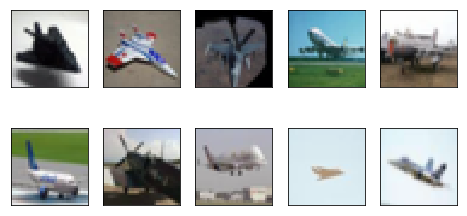

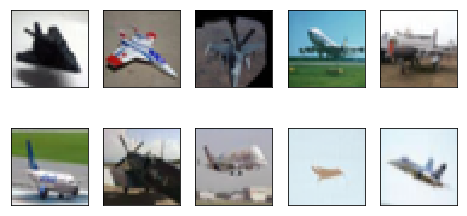

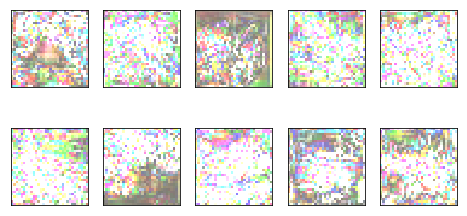


[ 0.32488793]
<NDArray 1 @gpu(0)> 
[  4.76837158e-07]
<NDArray 1 @gpu(0)> 
[ -9.86912441e+00  -2.08482239e-03  -6.36544371e+00  -7.56097026e-04
  -1.29099569e+01  -1.63791790e+01  -8.77298641e+00  -1.67165184e+01
  -9.67356682e+00  -3.26103444e-04  -9.58320904e+00  -1.27439041e+01
  -1.47055826e+01  -1.85242958e+01  -2.11743259e+01  -5.57029038e-04
  -9.45017529e+00  -1.07783480e+01  -6.61185198e-03  -1.61796017e+01
  -2.14909821e+01  -4.09990692e+00  -1.77345276e-02  -1.64930267e+01
  -8.31496611e-04  -2.30649662e+01  -4.13528204e+00  -1.24051437e+01
  -8.38707161e+00  -2.73827553e+00  -1.57833710e+01  -3.25388421e-04
  -1.94909859e+01  -1.34767847e+01  -1.42282009e+01  -9.94319153e+00
  -1.96462727e+01  -5.51516628e+00  -2.70382268e-03  -1.68530083e+01
  -1.49607754e+01  -1.13403902e+01  -9.80652523e+00  -1.75223160e+01
  -1.51741915e-04  -1.27307215e+01  -1.48830795e+01  -1.64197445e+01
  -6.47648470e-03  -1.10383692e+01  -1.94722080e+01  -4.07082653e+00
  -8.83895683e+00  -4.58383

In [75]:
for data, label in train_data:
    data = data.as_in_context(ctx)
    label = label.as_in_context(ctx)
    break
    
show_data(data[:10], False)
backgrad_data, (loss,_, _) = generate_backgrad_data(net, data.copy(), label, max_iters=10, lr=0.1, iter_log=False, clip=False)
show_data(backgrad_data[:10], False)
diff = nd.abs(data[:10] - backgrad_data[:10])
show_data(diff * 255, False)
print nd.max(diff), nd.min(diff), loss

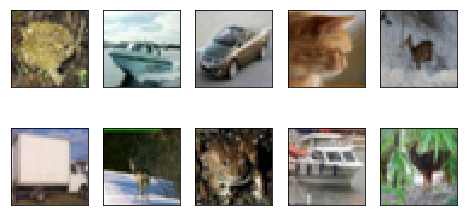

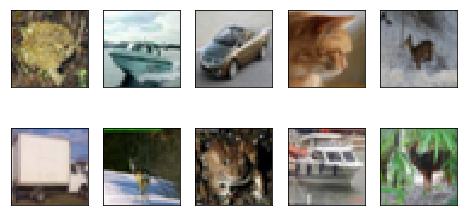

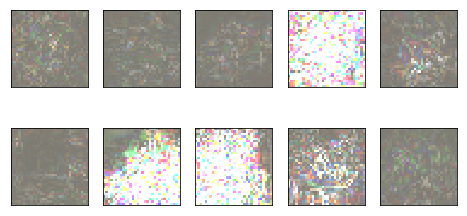


[ 0.40208346]
<NDArray 1 @gpu(0)> 
[ 0.]
<NDArray 1 @gpu(0)> 
[ -4.17231649e-06  -1.72957720e-04  -9.14293487e-05  -7.73375416e+00
  -1.53792789e-03   0.00000000e+00  -6.68036318e+00  -5.66346693e+00
  -9.75819156e-02  -7.23457837e-04  -3.77886317e-05  -1.07288304e-06
  -2.74180979e-06  -4.30610438e-04  -4.88756905e-06  -3.21864559e-06
  -1.14440263e-05  -1.26830637e-04  -6.37225201e-03  -9.22135368e-04
  -9.26941633e-03  -1.20619899e-02  -2.60080851e-04  -1.11335277e-04
  -4.24994668e-03  -6.57938013e-04  -2.63326359e+00  -5.48212440e-04
  -2.76050618e-04  -5.17591950e-04  -1.57173071e-03  -1.27175020e-03
  -1.64507474e-05  -7.57645583e-04  -1.00264475e-02  -3.29549797e-02
   0.00000000e+00  -2.90832186e+00  -1.75051737e+00  -3.63665894e-02
  -5.96046277e-07  -5.96046277e-07  -3.37067060e-04  -1.36008544e-04
  -6.64847554e-04  -1.73132657e-03  -9.41748931e-06  -8.22540733e-06
  -6.19100581e-04  -8.40046257e-03  -3.93389882e-06  -1.14672759e-04
  -1.43051045e-06  -1.68190163e-04  -2.6

In [77]:
train_data = gluon.data.DataLoader(train_ds, 128, shuffle=True, num_workers=0)
for data, label in train_data:
    data = data.as_in_context(ctx)
    label = label.as_in_context(ctx)
    break
    
show_data(data[:10], False)
backgrad_data, (loss,_, _) = generate_backgrad_data(net, data.copy(), label, max_iters=10, lr=0.1, iter_log=False, clip=False)
show_data(backgrad_data[:10], False)
diff = nd.abs(data[:10] - backgrad_data[:10])
show_data(diff * 255, False)
print nd.max(diff), nd.min(diff), loss